In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Загрузка данных

In [2]:
sales_train = pd.read_csv('../data/sales_train.csv.gz')
test = pd.read_csv('../data/test.csv.gz', index_col='ID')
items = pd.read_csv('../data/items.csv')
item_categories = pd.read_csv('../data/item_categories_enriched.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv', index_col='ID')
shops = pd.read_csv('../data/shops_enriched.csv')

Помним, что в итоге от нас требуется построить прогноз каждого товара тестовой выборки в каждом магазине тестовой выборки. По этой причине для тестирования модели надо выбрать какой-то магазин и построить прогноз по нему.

In [3]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


# Подумаем, какой прогноз надо строить в качестве примера

Прогноз будем строить по одному магазину, поэтому для начала выберем самый средний магазин. Для этого найдем магазин в городе, где в 2015 году было медианное население среди всех городов, упомянутых в данных.

In [4]:
shops.iloc[np.argmin(np.abs(shops['2015'] - shops['2015'].median()))]

shop_name    Красноярск ТЦ "Взлетка Плаза"
shop_id                                 17
is_mall                                  1
location                        Красноярск
2013                           1.01638e+06
2014                           1.03553e+06
2015                           1.05222e+06
Name: 17, dtype: object

In [5]:
np.sort(test['shop_id'].unique())

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)

Появилась Взлетка Плаза в Красноярске. Но это не лучший выбор, т.к. этого магазина нет в тестовой выборке. Зато в ней есть магазин с индексом 18, который тоже из Красноярска:

In [6]:
shops[shops['shop_id'] == 18]

,shop_name,shop_id,is_mall,location,2013,2014,2015
18,"Красноярск ТЦ ""Июнь""",18,1,Красноярск,1016385.0,1035528.0,1052218.0


Его и возьмем.

Посмотрим на номенклатуру его товаров в обучающей выборке:

In [7]:
shop18 = sales_train[sales_train['shop_id'] == 18]
len(shop18['item_id'].unique())

9073

И в тестовой:

In [8]:
len(test[test['shop_id'] == 18]['item_id'].unique())

5100

Помним, что не только в ТЦ Июнь, но и во всей тестовой выборке 5100 товаров. Похоже, в июне есть все товары тестовой выборки. Проверим это.

In [9]:
sum(np.isin(test[test['shop_id'] == 18]['item_id'].unique(), test['item_id'].unique()))

5100

Так и есть.

Для начала не будем выбирать все товары, а попробуем спрогнозировать какой-нибудь самый продаваемый. Найдем его.

In [10]:
shop18_sales = pd.DataFrame(shop18.groupby('item_id')['item_cnt_day'].sum())
shop18_sales.columns = ['item_cnt']

fig = plt.figure(figsize=(20, 5))
bar18_data = shop18_sales.sort_values('item_cnt', ascending=False).iloc[:15]
bar18_data = bar18_data.reset_index()
bar18_data.merge(items, on='item_id').merge(item_categories, on='item_category_id')\
                                        [['item_id', 'item_cnt', 'item_name', 'cat_1', 'cat_2']]

,item_id,item_cnt,item_name,cat_1,cat_2
0,20949,2826.0,Фирменный пакет майка 1С Интерес белый (34*42)...,Подарки,"Сумки, Альбомы, Коврики д/мыши"
1,3732,751.0,"Grand Theft Auto V [PS3, русские субтитры]",Игры,PS3
2,16787,368.0,"Одни из нас [PS3, русская версия]",Игры,PS3
3,3076,266.0,EA SPORTS MMA [PS3],Игры,PS3
4,4886,238.0,Mortal Kombat (Essentials) (с поддержкой 3D) [...,Игры,PS3
5,5822,550.0,Playstation Store пополнение бумажника: Карта ...,Карты оплаты,PSN
6,6675,351.0,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,Игровые консоли,PS4
7,2808,332.0,"Diablo III [PC, Jewel, русская версия]",Игры PC,Стандартные издания
8,3731,319.0,"Grand Theft Auto V [PC, русские субтитры]",Игры PC,Стандартные издания
9,6738,227.0,StarCraft II: Heart of the Swarm (дополнение) ...,Игры PC,Стандартные издания


<Figure size 1440x360 with 0 Axes>

Итого, в ТЦ Июнь самый продаваемый товар - это пакет-майка. Он вряд ли является полноценным товаром, за которым люди приходят в магазин. Скорее всего он коррелирует с общим количеством чеков, пробитых магазином. Большинство остального - это компьютерные игры. Таким образом, хорошими примерами товаров для прогнозирования в ТЦ Июнь являются:
1) Пакет-майка  
2) Grand Theft Auto V [PS3, русские субтитры] 

Ради интереса посмотрим на товары, проданные по всей России:

In [11]:
total_sales = pd.DataFrame(sales_train.groupby('item_id')['item_cnt_day'].sum())
total_sales.columns = ['item_cnt']

fig = plt.figure(figsize=(20, 5))
bar_data = total_sales.sort_values('item_cnt', ascending=False).iloc[:15]
bar_data = bar_data.reset_index()
bar_data.merge(items, on='item_id').merge(item_categories, on='item_category_id')\
                                        [['item_id', 'item_cnt', 'item_name', 'cat_1', 'cat_2']]

,item_id,item_cnt,item_name,cat_1,cat_2
0,20949,187642.0,Фирменный пакет майка 1С Интерес белый (34*42)...,Подарки,"Сумки, Альбомы, Коврики д/мыши"
1,2808,17245.0,"Diablo III [PC, Jewel, русская версия]",Игры PC,Стандартные издания
2,3731,10099.0,"Grand Theft Auto V [PC, русские субтитры]",Игры PC,Стандартные издания
3,1855,10032.0,"Battlefield 4 [PC, русская версия]",Игры PC,Стандартные издания
4,3331,8262.0,"FIFA 14 [PC, русская версия]",Игры PC,Стандартные издания
5,2445,7788.0,"Crysis 3 [PC, русская версия]",Игры PC,Стандартные издания
6,2308,7588.0,"Call of Duty: Black Ops II [PС, Jewel, русская...",Игры PC,Стандартные издания
7,3732,16642.0,"Grand Theft Auto V [PS3, русские субтитры]",Игры,PS3
8,16787,9227.0,"Одни из нас [PS3, русская версия]",Игры,PS3
9,17717,15830.0,Прием денежных средств для 1С-Онлайн,Служебные,NaN


<Figure size 1440x360 with 0 Axes>

В целом ситуация похожа. Разве что, здесь более популярны игры для ПК.

Итого, для ТЦ Июнь будем строить 2 прогноза: по пакетам и по игре GTA 5.

# Конструируем исходные данные для прогноза

Начнем с GTA 5

In [22]:
shop18_gta = shop18[shop18['item_id'] == 3732]
shop18_gta.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
858692,18.09.2013,8,18,3732,2534.000000,156.0
858694,19.09.2013,8,18,3732,2517.000000,30.0
858695,21.09.2013,8,18,3732,2580.428571,7.0
858714,30.09.2013,8,18,3732,2599.000000,22.0
858715,29.09.2013,8,18,3732,2599.000000,4.0


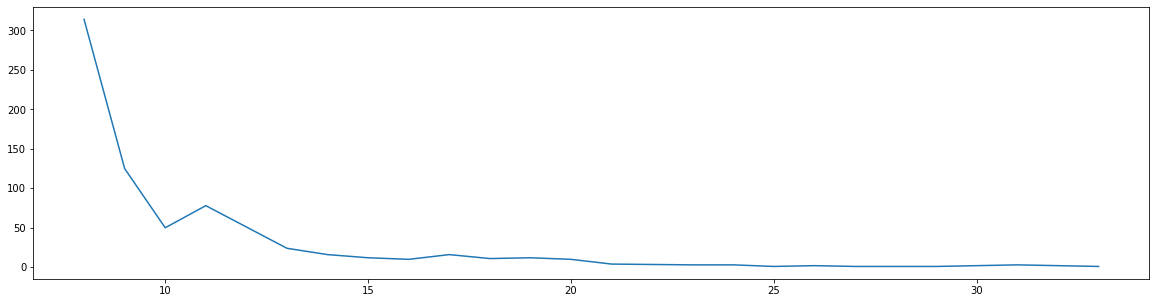

In [20]:
fig = plt.figure(figsize=(20, 5))
plt.plot(shop18_gta.groupby('date_block_num')['item_cnt_day'].sum())
plt.show()

Открылась очень интересная и очевидная закономерность: спрос на игры максимален после релиза, а потом он постепенно падает и к ноябрю 2015 находится около нулевой отметки. Посмотрим ту же GTA V на остальных магазинах тестовой выборки.

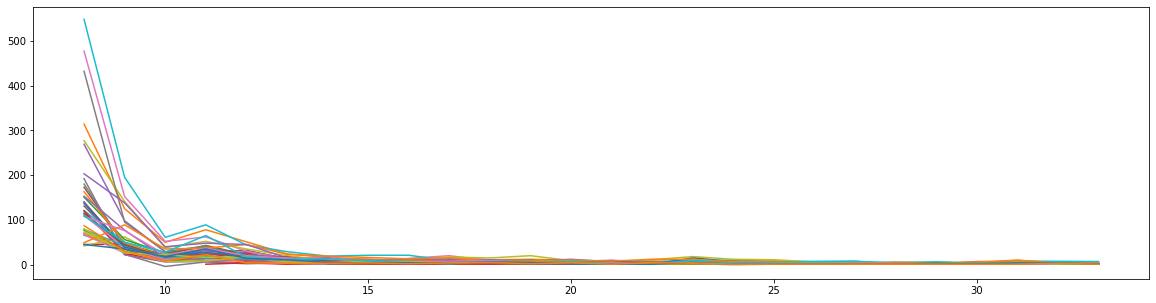

In [33]:
fig = plt.figure(figsize=(20, 5))
for shop_id in np.sort(test['shop_id'].unique()):
    shop = sales_train[sales_train['shop_id'] == shop_id]
    gta = shop[shop['item_id'] == 3732]    
    plt.plot(gta.groupby('date_block_num')['item_cnt_day'].sum())
plt.show()

А теперь другой вопрос: из наших 5100 товаров сколько являются видеоиграми?

In [68]:
test.merge(items).merge(item_categories)

,shop_id,item_id,item_name,item_category_id,item_category_name,cat_1,cat_2
0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,Игры,PS3
1,4,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,Игры,PS3
2,6,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,Игры,PS3
3,3,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,Игры,PS3
4,2,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,Игры,PS3
...,...,...,...,...,...,...,...
214195,46,168,1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра),Книги,Аудиокниги (Цифра)
214196,41,168,1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра),Книги,Аудиокниги (Цифра)
214197,44,168,1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра),Книги,Аудиокниги (Цифра)
214198,39,168,1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра),Книги,Аудиокниги (Цифра)


In [63]:
video_games = test.merge(items).merge(item_categories)
video_games = video_games[(video_games['cat_1'] == 'Игры') | (video_games['cat_1'] == 'Игры PC')]['item_id'].unique()
print(f'Видеоигр - {len(video_games)}')

Видеоигр - 1075


Это чуть более 20%. Посмотрим сначала, в каком количестве магазинов продается каждая игра. Понятно, что в каждом магазине тестовой выборки скорее всего представлены все 1075 игр. Но скорее всего на самом деле далеко не каждый магазин продает все 1075 игр.

In [71]:
sales_train.shape

(2935849, 6)

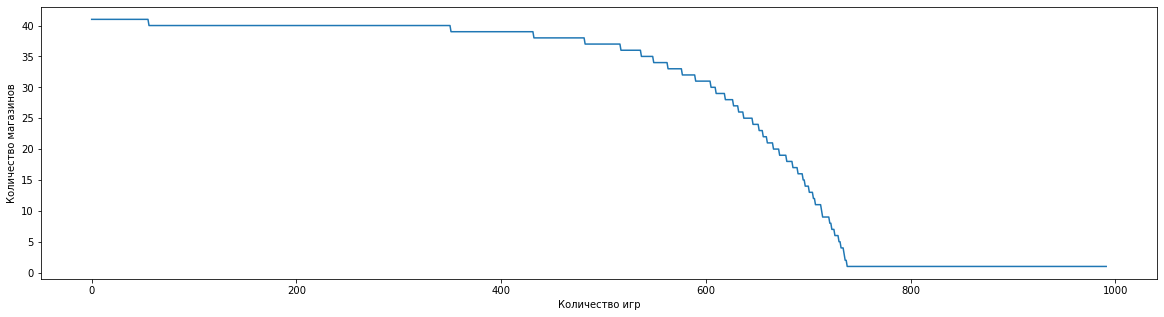

In [95]:
test_shops = test['shop_id'].unique()
game_by_shop = sales_train[np.isin(sales_train['shop_id'], test_shops) & np.isin(sales_train['item_id'], video_games)]\
[['shop_id', 'item_id']].drop_duplicates()
game_by_shop = game_by_shop.groupby('item_id')['shop_id'].count()
game_by_shop = game_by_shop.reset_index().sort_values('shop_id', ascending=False).reset_index()[['item_id', 'shop_id']]
fig = plt.figure(figsize=(20, 5))
plt.plot(game_by_shop['shop_id'])
plt.xlabel('Количество игр')
plt.ylabel('Количество магазинов')
plt.show()

In [91]:
game_by_shop

,item_id,shop_id
0,15040,41
1,7087,41
2,7003,41
3,4806,41
4,13159,41
...,...,...
987,4864,1
988,4848,1
989,4788,1
990,4767,1


In [69]:
#for i, game_id in enumerate(video_games):
#    fig = plt.figure(figsize=(20, 5))
#    for shop_id in np.sort(test['shop_id'].unique()):
#        shop = sales_train[sales_train['shop_id'] == shop_id]
#        gta = shop[shop['item_id'] == game_id]    
#        plt.plot(gta.groupby('date_block_num')['item_cnt_day'].sum())
#        plt.xlabel(f'{i + 1}. ' + items[items['item_id'] == game_id]['item_name'].values[0])        
#        plt.ylim(0, 200)
#    plt.show()

In [24]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [14]:
shop18_bag = shop18[shop18['item_id'] == 20949]
shop18_bag.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
378386,30.04.2013,3,18,20949,5.0,9.0
514874,11.05.2013,4,18,20949,5.0,13.0
514875,10.05.2013,4,18,20949,5.0,9.0
514876,09.05.2013,4,18,20949,5.0,9.0
514877,08.05.2013,4,18,20949,5.0,10.0


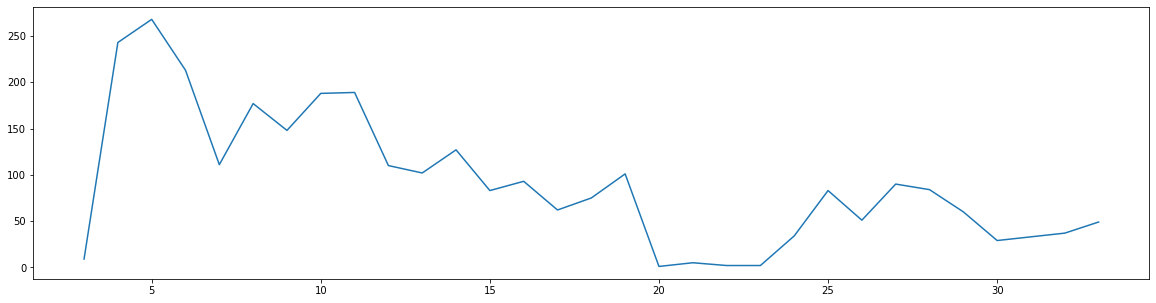

In [17]:
fig = plt.figure(figsize=(20, 5))
plt.plot(shop18_bag.groupby('date_block_num')['item_cnt_day'].sum())
plt.show()